## Setup

from https://camembert-model.fr/posts/tutorial/

from https://colab.research.google.com/drive/1ejBYmu0P5urzghoTTDB-GBUxpbUFX0Gz?usp=sharing#scrollTo=aN6M-KaApoRo

from https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi%20Label%20Text%20Classification%20using%20BERT%20PyTorch/bert_multilabel_pytorch_standard.ipynb

In [1]:
import os

import warnings
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

2023-07-12 16:21:54.203045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 16:21:55.125491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!nvidia-smi

/bin/bash: /home/aurelie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Wed Jul 12 16:21:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  Off |
|  0%   43C    P8    20W / 450W |   1451MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
https://www.youtube.com/watch?v=vNKIg8rXK6w&ab_channel=rupertai


In [3]:
# Setup torch
torch.set_float32_matmul_precision('high')
torch.manual_seed(42)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figs"

In [5]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Load Dataset

In [6]:
## load data (takes around 1min30s)
df_train = pd.read_pickle(os.path.join(data_path, "train_dataset_for_DL.pkl")).reset_index(drop=True)
print("Train dataset: ", df_train.shape)
df_test = pd.read_pickle(os.path.join(data_path, "test_dataset_for_DL.pkl")).reset_index(drop=True)
print("Test dataset: ", df_test.shape)
df_valid100 = pd.read_pickle(os.path.join(data_path, "valid100_dataset_for_DL.pkl"))
print("Validation dataset: ", df_valid100.shape)

Train dataset:  (125220, 103022)
Test dataset:  (29227, 103022)
Validation dataset:  (100, 103022)


In [7]:
# Check memory space
print("train dataset memory usage: ", df_train.info())
print()
print("ntest dataset memory usage: ", df_test.info())
print()
print("validation dataset memory usage: ", df_valid100.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125220 entries, 0 to 125219
Columns: 103022 entries, !Xóõ (langue) to descr
dtypes: Sparse[int64, 0](103021), object(1)
memory usage: 4.8+ MB
train dataset memory usage:  None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29227 entries, 0 to 29226
Columns: 103022 entries, !Xóõ (langue) to descr
dtypes: Sparse[int64, 0](103021), object(1)
memory usage: 1.1+ MB
ntest dataset memory usage:  None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 103022 entries, !Xóõ (langue) to descr
dtypes: Sparse[int64, 0](103021), object(1)
memory usage: 4.1+ KB
validation dataset memory usage:  None


In [8]:
# get one row
row_id = 64
label_cols = df_train.columns[:-1]
sample_row = df_train.iloc[row_id]
sample_descr = sample_row.descr
sample_labels = sample_row[label_cols]

print("Description: ", sample_descr)
print("Concepts: ", sample_labels[sample_labels != 0].to_dict())


Description:  La bataille mondiale des matières premières Dans le débat sur un nouvel ordre économique international, les marchés mondiaux des matières premières constituent un enjeu de première importance. Ils conditionnent largement les moyens de financement du développement de pays pauvres et sont un des lieux stratégiques où se joue l'indépendance des pays. L'auteur analyse d'abord les mécanismes et les acteurs des marchés libres, mettant en lumière les limites du jeu libéral de l'offre et de la demande. Son examen des divers systèmes de régulation qui ont été expérimentés l'amènent ensuite à émettre de sérieuses réserves sur l'efficacité des stocks régulateurs. De même, les accords compensatoires (type prêts du FMI) se heurtent-ils à des difficultés théoriques et concrètes de mise en place. La régulation de l'offre n'a véritablement réussi que dans le cas du pétrole. Des solutions plus radicales existent en dehors d'un fonctionnement aménagé du marché : ouverture unilatérale des f

In [9]:
""" # Sample datasets
df_train = df_train.sample(n=10000, random_state=42)
print("Train dataset: ", df_train.shape)
df_test = df_test.sample(n=3000, random_state=42)
print("Test dataset: ", df_test.shape) """

' # Sample datasets\ndf_train = df_train.sample(n=10000, random_state=42)\nprint("Train dataset: ", df_train.shape)\ndf_test = df_test.sample(n=3000, random_state=42)\nprint("Test dataset: ", df_test.shape) '

In [10]:
""" # Remove useless columns (labels not used in train dataset - Takes > 5min)
cols_to_remove = df_train.columns[df_train.sum() == 0]
len(cols_to_remove) """

' # Remove useless columns (labels not used in train dataset - Takes > 5min)\ncols_to_remove = df_train.columns[df_train.sum() == 0]\nlen(cols_to_remove) '

In [11]:
""" # Remove useless columns
df_train = df_train.drop(columns=cols_to_remove)
print("Train dataset:", df_train.shape)
df_test = df_test.drop(columns=cols_to_remove)
print("Test dataset:", df_test.shape)
df_valid100 = df_valid100.drop(columns=cols_to_remove)
print("Validation dataset:", df_valid100.shape)
label_cols = df_train.columns[:-1]
print("Nombre de labels:", len(label_cols)) """

' # Remove useless columns\ndf_train = df_train.drop(columns=cols_to_remove)\nprint("Train dataset:", df_train.shape)\ndf_test = df_test.drop(columns=cols_to_remove)\nprint("Test dataset:", df_test.shape)\ndf_valid100 = df_valid100.drop(columns=cols_to_remove)\nprint("Validation dataset:", df_valid100.shape)\nlabel_cols = df_train.columns[:-1]\nprint("Nombre de labels:", len(label_cols)) '

In [12]:
# Separate train dataset into train and validation sets for model 
from sklearn.model_selection import train_test_split
data_train, data_val = train_test_split(df_train, test_size = 0.3)
data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
print(data_train.shape, data_val.shape)

(87654, 103022) (37566, 103022)


In [13]:
# Set number of labels
n_labels = len(label_cols)

## Build the model

In [14]:
# Tokenization for camembert
from transformers import CamembertTokenizer, CamembertModel
model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)
bert_model = CamembertModel.from_pretrained(model_name, return_dict=True)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# example
notice = data_train.iloc[5].descr
print("description: ", notice)
print("\ntokenization: ", tokenizer.tokenize(notice)[:15])
print("\nEncodings: ", tokenizer.encode(notice)[:15])
print("\nRecoding: ", tokenizer.decode(tokenizer.encode(notice)))

description:  N°1 en maths avec Mathador CM1, 9-10 ans Un cahier de vacances fondé sur le jeu de calcul Mathador consistant à retrouver un nombre en utilisant d'autres nombres imposés. Ce faisant, l'enfant est invité à travailler sur les ordres de grandeur et le sens des nombres ainsi qu'à résoudre des problèmes en utilisant les quatre opérations. Avec des dés à construire soi-même

tokenization:  ['▁N', '°1', '▁en', '▁maths', '▁avec', '▁Math', 'ador', '▁CM', '1,', '▁9', '-10', '▁ans', '▁Un', '▁cahier', '▁de']

Encodings:  [5, 278, 7169, 22, 17865, 42, 12456, 10395, 8026, 5845, 419, 6686, 134, 153, 8221]

Recoding:  <s> N°1 en maths avec Mathador CM1, 9-10 ans Un cahier de vacances fondé sur le jeu de calcul Mathador consistant à retrouver un nombre en utilisant d'autres nombres imposés. Ce faisant, l'enfant est invité à travailler sur les ordres de grandeur et le sens des nombres ainsi qu'à résoudre des problèmes en utilisant les quatre opérations. Avec des dés à construire soi-même</

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Average length: 197.8
Max length: 1028


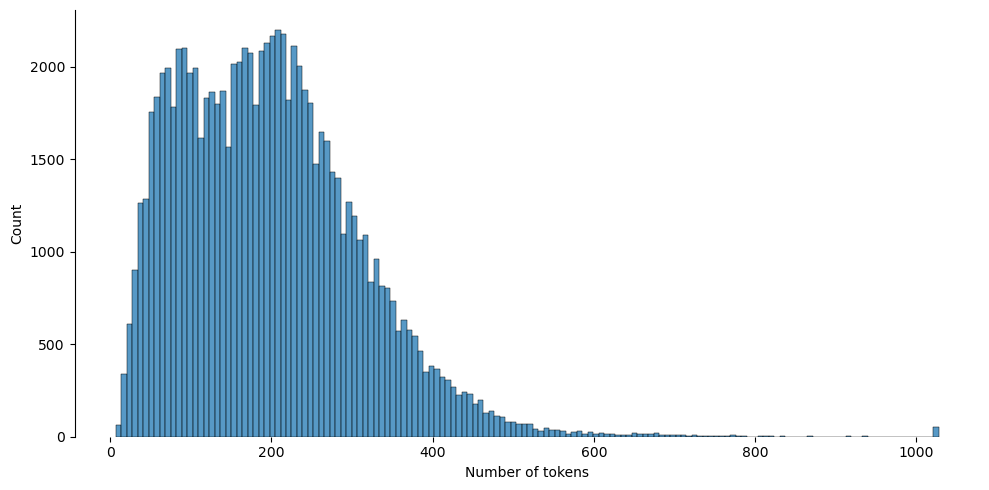

In [16]:
# Find number of tokens
import numpy as np
descr_len = [len(tokenizer.encode(descr, max_length=1028))
                          for descr in data_train["descr"]]
print("Average length: {:.1f}".format(np.mean(descr_len)))
print("Max length: {}".format(max(descr_len)))

plt.figure(figsize=(10,5))
ax = sns.histplot(descr_len, bins=150, kde=False)
ax.set(xlabel='Number of tokens')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig(os.path.join(fig_path, "number_of_tokens.png"), dpi=200)

In [17]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05

In [18]:
# Buid Dataset
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, max_len=128, device="cuda"):
        self.tokenizer = tokenizer
        self.df = df
        self.max_len = max_len

    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self, index: int):
        data_row = self.df.iloc[index]
        descr = data_row.descr
        title = " ".join(descr.split())
        self.targets = data_row[label_cols].values


        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets)
        }

In [33]:
train_dataset = CustomDataset(data_train, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(data_val, tokenizer, MAX_LEN)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [20]:
# Check dataset
sample = train_dataset[3]
print(sample['targets'].shape)
print(sample['input_ids'].shape)
print(sample['attention_mask'].shape)
print(sample['token_type_ids'].shape)

torch.Size([103021])
torch.Size([256])
torch.Size([256])
torch.Size([256])


In [34]:
# Build dataloaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    pin_memory=True,
    pin_memory_device="cuda",
    shuffle=True,
    num_workers=12
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    pin_memory=True,
    pin_memory_device="cuda",
    shuffle=False,
    num_workers=8
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=VALID_BATCH_SIZE,
    pin_memory=True,
    pin_memory_device="cuda",
    shuffle=False,
    num_workers=8
)

In [22]:
# Check that GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [23]:
import shutil

In [25]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)
     

In [26]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = bert_model
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, n_labels)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (bert_model): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [27]:
# Loss function and optimizer
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [28]:
# Set initial values
val_targets=[]
val_outputs=[]

In [29]:
# Run model
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path, steps_per_epochs=100):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
   
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        if batch_idx <= steps_per_epochs:
          print('yyy epoch', batch_idx)
          ids = data['input_ids'].to(device, dtype = torch.long)
          mask = data['attention_mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)

          outputs = model(ids, mask, token_type_ids)
          
          optimizer.zero_grad()
          loss = loss_fn(outputs, targets)
          if batch_idx%5000==0:
            print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          print('before loss data in training', loss.item(), train_loss)
          train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
          print('after loss data in training', loss.item(), train_loss)
    
        else:
          break

    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            if batch_idx <= steps_per_epochs: 
              ids = data['input_ids'].to(device, dtype = torch.long)
              mask = data['attention_mask'].to(device, dtype = torch.long)
              token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
              targets = data['targets'].to(device, dtype = torch.float)
              outputs = model(ids, mask, token_type_ids)

              loss = loss_fn(outputs, targets)
              valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
              val_targets.extend(targets.cpu().detach().numpy().tolist())
              val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            else:
               break

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [30]:
# Defin paths
ckpt_path = "./runs/camemBert/curr_ckpt"
best_model_path = "./runs/camemBert/best_model.pt"

In [30]:
# Train model
from datetime import datetime
start = datetime.now()
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path, steps_per_epochs=100)
end =  datetime.now()
duration = end-start
print("time elapsed:", duration)

############# Epoch 1: Training Start   #############
yyy epoch 0
Epoch: 1, Training Loss:  0.6937242150306702
before loss data in training 0.6937242150306702 0
after loss data in training 0.6937242150306702 0.6937242150306702
yyy epoch 1
before loss data in training 0.6934462785720825 0.6937242150306702
after loss data in training 0.6934462785720825 0.6935852468013763
yyy epoch 2
before loss data in training 0.6931669116020203 0.6935852468013763
after loss data in training 0.6931669116020203 0.6934458017349243
yyy epoch 3
before loss data in training 0.6928974986076355 0.6934458017349243
after loss data in training 0.6928974986076355 0.6933087259531021
yyy epoch 4
before loss data in training 0.6926557421684265 0.6933087259531021
after loss data in training 0.6926557421684265 0.693178129196167
yyy epoch 5
before loss data in training 0.6923778653144836 0.693178129196167
after loss data in training 0.6923778653144836 0.6930447518825531
yyy epoch 6
before loss data in training 0.6921454

: 

: 

In [ ]:
# Load model

In [49]:
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['valid_loss_min']

model.eval()

BERTClass(
  (bert_model): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [40]:
# testing
example = df_valid100['descr'][98]
print("Description: ", example)
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)


preds = []
model.eval()
with torch.no_grad():
    for text in df_valid100["descr"]:
        print("Description: ", text)
        encodings = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt')
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        output = model(input_ids, attention_mask, token_type_ids)
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
        print(df_valid100.columns[:-1].to_list()[int(np.argmax(final_output, axis=1))])
        preds.append(final_output)
        

Description:  Le coenseignement en pratique Présentation et analyse de tous les aspects du coenseignement, ses particularités et ses bénéfices, tant du point de vue des élèves que des professeurs. Ce guide explique comment mettre en place cette façon d'enseigner en abordant plusieurs points techniques : la forme, la posture des enseignants, la répartition des apprentissages, l'autorité, l'évaluation, entre autres.
Description:  Les sommets de l'État : essai sur l'élite du pouvoir en France u XIXe siècle à nos jours, l'Etat "fort" à la française a connu bien des vicissitudes que l'on se propose de retracer ici. Institution prestigieuse attirant vers elle les élites de la nation issues des Grandes Ecoles, l'Etat organise les activités les plus diverses grâce à son armée de fonctionnaires fidèles à la logique de leur rôle et aux valeurs du service public. Les élites politiques et celles de l'Etat en viennent alors souvent à se confondre, d'autant que l'état demeure fermé aux intrus du mon

In [52]:
final_output

[[0.5087566375732422,
  0.5124032497406006,
  0.5132208466529846,
  0.5153500437736511,
  0.49287381768226624,
  0.5066041350364685,
  0.4946262538433075,
  0.4659135639667511,
  0.5077733397483826,
  0.5057207345962524,
  0.4824887812137604,
  0.47844627499580383,
  0.5210345983505249,
  0.5154179334640503,
  0.513576090335846,
  0.5031613707542419,
  0.5324522852897644,
  0.5125325918197632,
  0.46676015853881836,
  0.510063886642456,
  0.4849981665611267,
  0.511141300201416,
  0.4978821873664856,
  0.4982639253139496,
  0.4959043562412262,
  0.5029359459877014,
  0.5196188688278198,
  0.49992048740386963,
  0.500252366065979,
  0.4984060227870941,
  0.5226011872291565,
  0.49930810928344727,
  0.4976603090763092,
  0.5147148966789246,
  0.48331931233406067,
  0.4911966919898987,
  0.4955936372280121,
  0.5148219466209412,
  0.5056673884391785,
  0.49778634309768677,
  0.5052366256713867,
  0.5104638934135437,
  0.4688869118690491,
  0.5139185190200806,
  0.49960044026374817,
  0.49

: 

In [ ]:
model.eval()
_, preds = trained_model(encodings["input_ids"], encodings["attention_mask"])
preds = preds.flatten().detach().numpy()

In [ ]:
predictions = []
for idx, label in enumerate(label_cols):
    if preds[idx] > 0.05:
        predictions.append((label, round(preds[idx]*100, 2)))

predictions

In [ ]:
example

In [ ]:
from torch.utils.data import Dataset, DataLoader

class RameauLabelDataset(Dataset):

    def __init__(self, data: pd.DataFrame, tokenizer: tokenizer, max_token_len: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        descr = " ".join(data_row.descr.split())
        labels = data_row[label_cols]

        inputs = self.tokenizer(
            descr,
            None,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=True,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            "labels": torch.FloatTensor(labels),
            "descr": descr
        }

In [ ]:
# Encode all datasets
train_dataset = RameauLabelDataset(
  data_train,
  tokenizer,
  max_token_len=MAX_LEN
)
val_dataset = RameauLabelDataset(
  data_val,
  tokenizer,
  max_token_len=MAX_LEN
)
test_dataset = RameauLabelDataset(
  df_test,
  tokenizer,
  max_token_len=MAX_LEN
)

In [ ]:
#Utility to load dataset in batch
from torch.utils.data import DataLoader
#Importing camembdert and AdamW Optimizer
from transformers import CamembertForSequenceClassification, AdamW


In [ ]:
#Model declaration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CamembertForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.train()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

#### Prepare data

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [ ]:
lightning_model = LightningModel(model_name, n_labels, lr=3e-5, weight_decay=0.1)

In [ ]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu",
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

In [ ]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=model_checkpoint.best_model_path)

In [ ]:
ID_TO_LABEL = dataset["train"].features["Label"].names

In [ ]:
def get_preds(model, tokenizer, sentence):
    tokenized_sentence = tokenizer(sentence, return_tensors="pt")
    input_ids, attention_mask = tokenized_sentence.input_ids, tokenized_sentence.attention_mask

    out = model(
        input_ids=tokenized_sentence.input_ids,
        attention_mask=tokenized_sentence.attention_mask
    )

    logits = out.logits

    probas = torch.softmax(logits, -1).squeeze()

    pred = torch.argmax(probas)

    return ID_TO_LABEL[pred], probas[pred].item()

In [ ]:
test_sentence = "Bonjour, vous allez bien ?"

label_predicted, proba = get_preds(lightning_model.model, tokenizer, test_sentence)

print(f"Label: {label_predicted}, confidence: {proba:.2f}")

In [ ]:
# Metrics
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
     

In [ ]:
# Define Trainer
from apex import amp
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="outputs",
    num_train_epochs=1,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses

In [ ]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-05
THRESHOLD = 0.2 # threshold for the sigmoid

### Data module

In [ ]:
from transformers import BertForSequenceClassification

bertclassifier, li = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=n_labels,output_loading_info=True) 

In [ ]:
print(bertclassifier)

In [ ]:
for i, name_param in enumerate(bertclassifier.named_parameters()):
    print(i, name_param[0])
    # we freeze first 21 layers (first encoder)
    if i <= 20:
        name_param[1].requires_grad = False

In [ ]:
input_ids = torch.tensor(tokenizer.encode(train_dataset[0], add_special_tokens=True, max_length = 512, truncation = True))
bertclassifier.eval()
bertclassifier(input_ids)

In [ ]:
# checking the frozen layers 
print(list(bertclassifier.parameters())[20].requires_grad)

# trainable layer
print(list(bertclassifier.parameters())[-100].requires_grad)

## Writing the DataLoader

In [ ]:
# Data Module
class RameauLabelDataModule(pl.LightningDataModule):

    def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = RameauLabelDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )
            
        self.val_dataset = RameauLabelDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )
        self.test_dataset = RameauLabelDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=1,
            num_workers=4
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=2
        )

In [ ]:
# Instantiate and set up the data_module
data_module = RameauLabelDataModule(
    data_train, 
    data_val, 
    df_test, 
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len = MAX_LEN)

data_module.setup()

In [ ]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)
print(train_dataset[0][2])

In [ ]:
# let's look at few examples

for i_batch, sample_batch in enumerate(train_dataset):
    print(i_batch)
    X, mask_X, y = sample_batch
    print(X.shape)
    print(mask_X.shape)
    print(y.shape)
    if i_batch == 10:
        break

In [ ]:
## Start training

In [ ]:
import transformers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cuda for gpu acceleration

# optimizer

optimizer = transformers.AdamW(bertclassifier.parameters(), lr = 1e-5)


bertclassifier.to(device) # taking the model to gpu if possible

In [ ]:
# training epochs

epochs = 2

# metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_losses = []

train_metrics = {'acc': [], 'f1': []}
test_metrics = {'acc': [], 'f1': []}

# progress bar

from tqdm import tqdm_notebook

for e in tqdm_notebook(range(epochs)):
    train_loss = 0.0
    train_acc = 0.0
    train_f1 = 0.0
    batch_cnt = 0
    
    bertclassifier.train()
    
    print(f'epoch: {e+1}')
    
    for i_batch, (X, X_mask, y) in tqdm_notebook(enumerate(bbc_dataloader_train)):
        X = X.to(device)
        X_mask = X_mask.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
        
        loss, y_pred = bertclassifier(X, attention_mask = X_mask, labels = y)

        train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(bertclassifier.parameters(), 1.0)

        optimizer.step()
        
        y_pred = torch.argmax(y_pred, dim = -1)
        
        # update metrics
        train_acc += accuracy_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        train_f1 += f1_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average = 'weighted')
        batch_cnt += 1
    
    print(f'train loss: {train_loss/batch_cnt}')
    print(f'acc: {train_acc/batch_cnt}')
    print(f'f1: {train_f1/batch_cnt}')
    train_losses.append(train_loss/batch_cnt)
    train_metrics['acc'].append(train_acc/batch_cnt)
    train_metrics['f1'].append(train_f1/batch_cnt)
        
        
    test_loss = 0.0
    test_acc = 0.0
    test_f1 = 0.0
    batch_cnt = 0
    
    bertclassifier.eval()
    with torch.no_grad():
        for i_batch, (X, X_mask, y) in enumerate(bbc_dataloader_train):
            X = X.to(device)
            X_mask = X_mask.to(device)
            y = y.to(device)

            y_pred = bertclassifier(X, attention_mask = X_mask, labels = y)[1] # in eval model we get the softmax output so, don't need to index

            
            y_pred = torch.argmax(y_pred, dim = -1)

            # update metrics
            test_acc += accuracy_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
            test_f1 += f1_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average = 'weighted')
            batch_cnt += 1
            
    test_metrics['acc'].append(test_acc/batch_cnt)
    test_metrics['f1'].append(test_f1/batch_cnt)
    print(f'test acc: {test_acc/batch_cnt}')
    print(f'test f1: {test_f1/batch_cnt}')

In [ ]:
# plotting the result

import matplotlib.pyplot as plt

plt.plot(train_metrics['acc'], 'kx')
plt.plot(train_metrics['f1'], 'r')
plt.legend(['train acc', 'train f1'])
plt.show()
plt.plot(test_metrics['acc'], 'bx')
plt.plot(test_metrics['f1'], 'y')
plt.legend(['test acc', 'test f1'])
plt.show()

### Bert model

In [ ]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics import AUROC
import torch.nn.functional as F

In [ ]:
# Model
class RameauLabelClassifier(pl.LightningModule):
  
  # Set up the classifier
  def __init__(self, config:dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()
    
  def forward(self, input_ids, attention_mask, labels=None):
    # model layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss ", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    total_steps = self.config['train_size']/self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]

  def validation_epoch_end(self, outputs):
    losses = []
    for output in outputs:
       loss = output['val_loss'].detach().cpu()
       losses.append(loss)
    avg_loss = torch.mean(torch.stack(losses))
    self.log("avg_val_loss", avg_loss)

In [ ]:
config = {
    'model_name': 'bert-base-multilingual-uncased',
    'n_labels': len(label_cols),
    'batch_size': 16,
    'lr': 2.5e-6,
    'warmup': 0.2, 
    'train_size': len(RameauLabelDataModule.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 4
}

model = RameauLabelClassifier(config)

### Train model

In [ ]:
# data module
data_module = data_module = RameauLabelDataModule(
    data_train, 
    data_val, 
    df_test, 
    tokenizer=tokenizer,
    batch_size=config['batch_size'])
data_module.setup()

# model
model = RameauLabelClassifier(config)

# trainer and fit
trainer = pl.Trainer(max_epochs=config["n_epochs"], accelerator="auto", enable_progress_bar=True)
trainer.fit(model, data_module)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

### Predict with model

In [ ]:
# method to convert list of comments into predictions for each comment
def classify_raw_comments(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, label in enumerate(labels):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('BERT Trained on Rameau Dataset - AUC ROC')